In [2]:
# Importação de bibliotecas necessárias
import numpy as np
import pandas as pd
import autosklearn.regression
from autosklearn.metrics import mean_squared_error as autosklearn_mse
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import logging
import shutil
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble._hist_gradient_boosting.gradient_boosting import HistGradientBoostingRegressor
from inspect import signature


In [3]:
# Configuração inicial de logging
logging.basicConfig(level=logging.INFO)

# Diretório temporário (configurável pelo usuário)
TEMP_DIR = './auto-sklearn-temp'  # Caminho genérico para evitar referências locais

# Garantir que o diretório temporário esteja limpo
if os.path.exists(TEMP_DIR):
    shutil.rmtree(TEMP_DIR)

print("Configuração inicial concluída. Diretório temporário limpo.")


Configuração inicial concluída. Diretório temporário limpo.


In [3]:
# Carregar o conjunto de dados California Housing
california_housing = fetch_california_housing()
X = pd.DataFrame(california_housing.data, columns=california_housing.feature_names)
y = california_housing.target

# Divisão entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Conjunto de dados carregado e dividido em treino e teste.")


Conjunto de dados carregado e dividido em treino e teste.


In [ ]:
# Baseline com Regressão Linear
from sklearn.linear_model import LinearRegression

print("Treinando Regressão Linear...")
modelo_linear = LinearRegression()
modelo_linear.fit(X_train, y_train)

# Previsões e avaliação
y_pred_linear = modelo_linear.predict(X_test)
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print(f"MSE da Regressão Linear: {mse_linear:.4f}")
print(f"R² da Regressão Linear: {r2_linear:.4f}")


Treinando Regressão Linear...
MSE da Regressão Linear: 0.5559
R² da Regressão Linear: 0.5758


In [5]:
# Treinamento com Auto-Sklearn
print("Treinando Auto-Sklearn...")
autoMl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=600,
    per_run_time_limit=120,
    n_jobs=-1,
    tmp_folder=TEMP_DIR,
    delete_tmp_folder_after_terminate=False,
    include={
        'regressor': [
            'random_forest', 'gradient_boosting', 'extra_trees',
            'adaboost', 'k_nearest_neighbors', 'liblinear_svr',
            'sgd', 'mlp'
        ]
    },
    ensemble_kwargs={'ensemble_size': 50},
    ensemble_nbest=20
)
autoMl.fit(X_train, y_train)

# Previsões e avaliação
y_pred_automl = autoMl.predict(X_test)
mse_automl = mean_squared_error(y_test, y_pred_automl)
r2_automl = r2_score(y_test, y_pred_automl)

print(f"MSE do Auto-Sklearn: {mse_automl:.4f}")
print(f"R² do Auto-Sklearn: {r2_automl:.4f}")


Treinando Auto-Sklearn...
[WARNING] [2025-03-02 11:52:10,294:Client-AutoMLSMBO(1)::e7c5e6b5-f775-11ef-be6f-10f60a03a7f5] Configuration 211 not found
[WARNING] [2025-03-02 11:52:10,294:Client-AutoMLSMBO(1)::e7c5e6b5-f775-11ef-be6f-10f60a03a7f5] Configuration 31 not found
[WARNING] [2025-03-02 11:52:10,294:Client-AutoMLSMBO(1)::e7c5e6b5-f775-11ef-be6f-10f60a03a7f5] Configuration 82 not found
[WARNING] [2025-03-02 11:52:10,294:Client-AutoMLSMBO(1)::e7c5e6b5-f775-11ef-be6f-10f60a03a7f5] Configuration 102 not found
[WARNING] [2025-03-02 11:52:10,294:Client-AutoMLSMBO(1)::e7c5e6b5-f775-11ef-be6f-10f60a03a7f5] Configuration 54 not found
[WARNING] [2025-03-02 11:52:10,295:Client-AutoMLSMBO(1)::e7c5e6b5-f775-11ef-be6f-10f60a03a7f5] Configuration 73 not found
[WARNING] [2025-03-02 11:52:10,295:Client-AutoMLSMBO(1)::e7c5e6b5-f775-11ef-be6f-10f60a03a7f5] Configuration 79 not found
[WARNING] [2025-03-02 11:52:10,295:Client-AutoMLSMBO(1)::e7c5e6b5-f775-11ef-be6f-10f60a03a7f5] Configuration 174 not f

In [6]:
# Exibir modelos encontrados pelo Auto-Sklearn
print("\nModelos encontrados pelo Auto-Sklearn:")
print(autoMl.show_models())

# Melhor modelo e seu peso
models_with_weights = autoMl.get_models_with_weights()
best_weight, best_model = models_with_weights[0]

print(f"\nMelhor modelo encontrado (peso no ensemble: {best_weight}):")
print(best_model)



Modelos encontrados pelo Auto-Sklearn:
{4: {'model_id': 4, 'rank': 1, 'cost': 0.1620715712517813, 'ensemble_weight': 0.1, 'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice object at 0x761147b10580>, 'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice object at 0x7610e318ea90>, 'regressor': <autosklearn.pipeline.components.regression.RegressorChoice object at 0x7610e318e250>, 'sklearn_regressor': HistGradientBoostingRegressor(l2_regularization=1.3053128884667706e-10,
                              learning_rate=0.05594167483605857, max_iter=512,
                              max_leaf_nodes=85, min_samples_leaf=10,
                              n_iter_no_change=4, random_state=1,
                              validation_fraction=None, warm_start=True)}, 5: {'model_id': 5, 'rank': 2, 'cost': 0.16772447366670795, 'ensemble_weight': 0.06, 'data_preprocessor': <autosklearn.pipeline.components.d

In [7]:
print("\nTreinando o melhor modelo manualmente...")

# Obter os parâmetros do melhor modelo
best_model_params = best_model.get_params()

# Filtrar os parâmetros válidos para o HistGradientBoostingRegressor
valid_params = signature(HistGradientBoostingRegressor).parameters
filtered_params = {
    key.replace('regressor__choice__', ''): value
    for key, value in best_model_params.items()
    if key.replace('regressor__choice__', '') in valid_params
}

# Criar e treinar o modelo manualmente
manual_model = HistGradientBoostingRegressor(**filtered_params)
manual_model.fit(X_train, y_train)

# Fazer previsões e avaliar o modelo manual
y_pred_manual = manual_model.predict(X_test)
mse_manual = mean_squared_error(y_test, y_pred_manual)
r2_manual = r2_score(y_test, y_pred_manual)

print(f"MSE do Melhor Modelo Manual: {mse_manual:.4f}")
print(f"R² do Melhor Modelo Manual: {r2_manual:.4f}")



Treinando o melhor modelo manualmente...
MSE do Melhor Modelo Manual: 0.2171
R² do Melhor Modelo Manual: 0.8343



Análise de Importância das Features (Permutação):
      Feature  Importance
6    Latitude    0.836032
7   Longitude    0.696999
0      MedInc    0.545549
5    AveOccup    0.154518
1    HouseAge    0.040715
2    AveRooms    0.033489
4  Population    0.005707
3   AveBedrms    0.005587


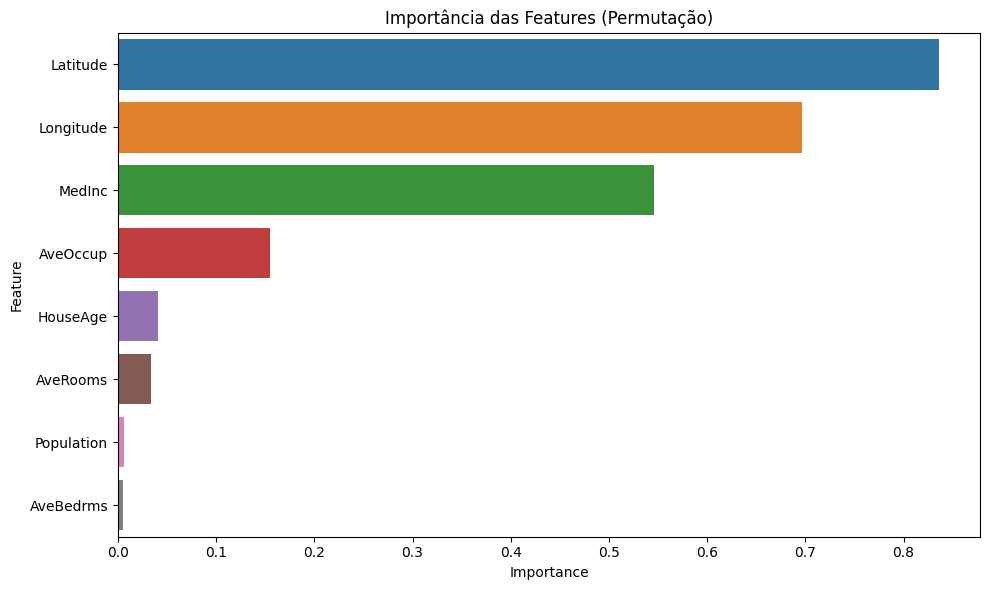

In [8]:
# Importância das features usando permutação
perm_importance = permutation_importance(manual_model, X_test, y_test, n_repeats=10, random_state=42)

# Organizar os resultados em um DataFrame
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

# Exibir as importâncias das features
print("\nAnálise de Importância das Features (Permutação):")
print(importance_df)

# Visualizar as importâncias das features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Importância das Features (Permutação)')
plt.tight_layout()
plt.show()


In [9]:
# Avaliação com Cross-Validation
print("\nAvaliação com Cross-Validation (5 Folds):")
cv_scores = cross_val_score(manual_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_mse_scores = -cv_scores  # Inverter o sinal para obter o MSE positivo

print(f"Scores de MSE em cada Fold: {cv_mse_scores}")
print(f"Média do MSE: {cv_mse_scores.mean():.4f}")
print(f"Desvio Padrão do MSE: {cv_mse_scores.std():.4f}")



Avaliação com Cross-Validation (5 Folds):
Scores de MSE em cada Fold: [0.38098504 0.32657076 0.37331497 0.35760094 0.45570852]
Média do MSE: 0.3788
Desvio Padrão do MSE: 0.0427


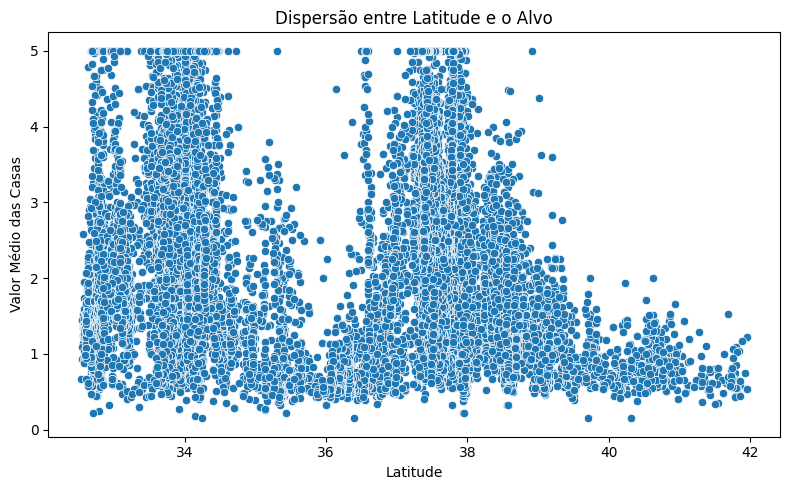

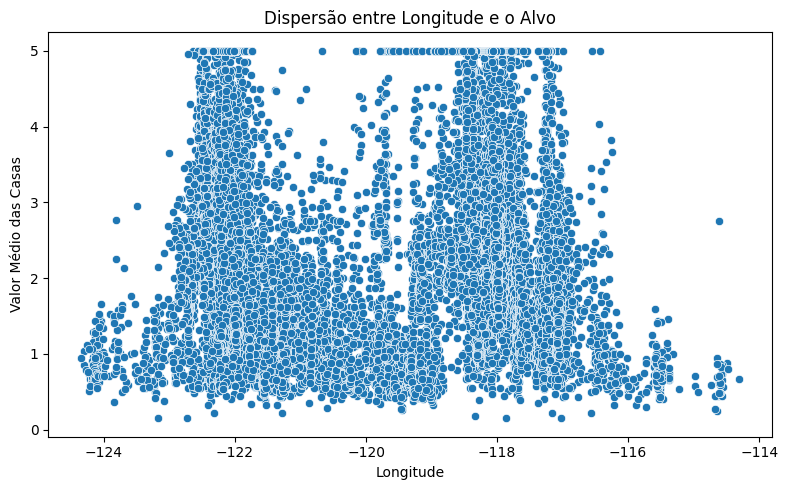

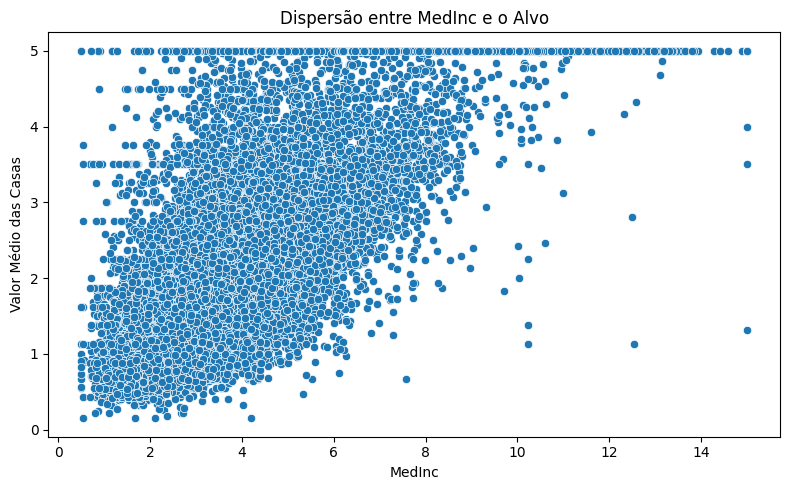

In [10]:
# Visualização detalhada das features mais importantes
top_features = importance_df.head(3)['Feature']
for feature in top_features:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=X[feature], y=y)
    plt.title(f'Dispersão entre {feature} e o Alvo')
    plt.xlabel(feature)
    plt.ylabel('Valor Médio das Casas')
    plt.tight_layout()
    plt.show()
